# ACOL replication tensorflow

## Setup stuff

In [1]:
import random
from notifiers import notify
#imports and settings:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#from jupyterthemes import jtplot
from sklearn.cluster import KMeans
from scipy.stats import threshold
from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.contrib.learn.python.learn.datasets import mnist
#jtplot.style()
%matplotlib inline
tf.logging.set_verbosity(tf.logging.INFO)

TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
TEST_LABELS = 't10k-labels-idx1-ubyte.gz'
SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'

local_file = base.maybe_download(TRAIN_IMAGES, './MNIST_data',
                                   SOURCE_URL + TRAIN_IMAGES)
with open(local_file, 'rb') as f:
    train_images = mnist.extract_images(f)
    
local_file = base.maybe_download(TRAIN_LABELS, './MNIST_data',
                                   SOURCE_URL + TRAIN_LABELS)
with open(local_file, 'rb') as f:
    train_labels = mnist.extract_labels(f, one_hot=True)

local_file = base.maybe_download(TEST_IMAGES, './MNIST_data',
                                   SOURCE_URL + TEST_IMAGES)
with open(local_file, 'rb') as f:
    test_images = mnist.extract_images(f)

local_file = base.maybe_download(TEST_LABELS, './MNIST_data',
                                   SOURCE_URL + TEST_LABELS)
with open(local_file, 'rb') as f:
    test_labels = mnist.extract_labels(f, one_hot=True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
clustCount = 5
classCount = 2
net = 0
#trainsteps = 50000
trainsteps = 25000
validation_size=5000*2
_epochs_completed_train = 0
_index_in_epoch_train = 0
_epochs_completed_val = 0
_index_in_epoch_val = 0
_epochs_completed_test = 0
_index_in_epoch_test = 0

In [3]:
y = {0:[1,0],
     1:[1,0],
     2:[1,0],
     3:[1,0],
     4:[1,0],
     5:[0,1],
     6:[0,1],
     7:[0,1],
     8:[0,1],
     9:[0,1]}
y2 = {
    0:np.zeros((classCount,clustCount)),
    1:np.zeros((classCount,clustCount)),
    2:np.zeros((classCount,clustCount)),
    3:np.zeros((classCount,clustCount)),
    4:np.zeros((classCount,clustCount)),
    5:np.zeros((classCount,clustCount)),
    6:np.zeros((classCount,clustCount)),
    7:np.zeros((classCount,clustCount)),
    8:np.zeros((classCount,clustCount)),
    9:np.zeros((classCount,clustCount))
}
y2[5][0,0] = 1 #NOTE
y2[6][0,1] = 1
y2[7][0,2] = 1
y2[8][0,3] = 1
y2[9][0,4] = 1
#y2[5][0,5] = 1
#y2[6][0,6] = 1
#y2[7][0,7] = 1
#y2[8][0,8] = 1
#y2[9][0,9] = 1

#emptyy2 = {
#    0:np.zeros((classCount,clustCount)),
#    1:np.zeros((classCount,clustCount)),
#    2:np.zeros((classCount,clustCount)),
#    3:np.zeros((classCount,clustCount)),
#    4:np.zeros((classCount,clustCount)),
#    5:np.zeros((classCount,clustCount)),
#    6:np.zeros((classCount,clustCount)),
#    7:np.zeros((classCount,clustCount)),
#    8:np.zeros((classCount,clustCount)),
#    9:np.zeros((classCount,clustCount))
#}

In [4]:
#train_super_labels = np.array([y[np.argmax(train_labels[j])] for j in range(train_labels.shape[0])])
#test_super_labels = np.array([y[np.argmax(test_labels[j])] for j in range(test_labels.shape[0])])

#train_labels = np.array([y2[np.argmax(train_labels[j])] for j in range(train_labels.shape[0])])

#test_labels = np.array([y2[np.argmax(test_labels[j])] for j in range(test_labels.shape[0])])

In [5]:
imFlipper = [slice(None)] * 3
imFlipper[2] = slice(None, None, -1)

lblFlipper = [slice(None)] * 3
lblFlipper[1] = slice(None, None, -1)
#train_l = train_images.shape[0]
#test_l = test_images.shape[0]
#print train_images.shape
#train_images = np.vstack([train_images,train_images[tuple(indexer)]])
#test_images = np.vstack([test_images,test_images[tuple(indexer)]])

#train_super_labels = np.vstack([np.hstack([np.zeros(train_l),np.ones(train_l)]),np.hstack([np.ones(train_l),np.zeros(train_l)])])
#test_super_labels = np.vstack([np.hstack([np.zeros(test_l),np.ones(test_l)]),np.hstack([np.ones(test_l),np.zeros(test_l)])])

#train_labels = np.vstack([train_labels,train_labels])
#test_labels = np.vstack([test_labels,test_labels])

In [6]:
print(train_images.shape)
print(train_labels.shape)    
    
trainSel = np.argmax(train_labels,1)>=classCount #NOTE
print(len(trainSel))
print(trainSel[:20])
testSel = np.argmax(test_labels,1)>=classCount #NOTE
print(len(testSel))
print(testSel[:20])

(60000, 28, 28, 1)
(60000, 10)
60000
[ True False  True False  True  True False  True False  True  True  True
  True  True False  True  True  True  True  True]
10000
[ True  True False False  True False  True  True  True  True False  True
  True False False  True  True  True  True  True]


In [7]:
#shuffle before selecting validation and test subsets
#perm0 = np.arange(train_l*2)
#np.random.shuffle(perm0)
#train_images = train_images[perm0]
#train_labels = train_labels[perm0]
#train_super_labels = train_super_labels[perm0]

#perm1 = np.arange(test_l*2)
#np.random.shuffle(perm1)
#test_images = test_images[perm1]
#test_labels = test_labels[perm1]
#test_super_labels = test_super_labels[perm1]

train_images = train_images[trainSel,:,:,:]
train_labels = train_labels[trainSel,:]

print(train_images.shape)

test_images = test_images[testSel,:,:,:]
test_labels = test_labels[testSel,:]

train_labels = np.array([y2[np.argmax(train_labels[j])] for j in range(train_labels.shape[0])])
test_labels = np.array([y2[np.argmax(test_labels[j])] for j in range(test_labels.shape[0])])

(47335, 28, 28, 1)


In [8]:
if not 0 <= validation_size <= len(train_images):
    raise ValueError(
        'Validation size should be between 0 and {}. Received: {}.'
        .format(len(train_images), validation_size))

validation_images = train_images[:validation_size]
validation_labels = train_labels[:validation_size]
#validation_labels_clipped = train_labels_clipped[:validation_size]
train_images = train_images[validation_size:]
train_labels = train_labels[validation_size:]
#train_labels_clipped = train_labels_clipped[validation_size:]

train_images = train_images.reshape(train_images.shape[0],train_images.shape[1] * train_images.shape[2])
train_images = train_images.astype(np.float32)
train_images = np.multiply(train_images, 1.0 / 255.0)

validation_images = validation_images.reshape(validation_images.shape[0],validation_images.shape[1] * validation_images.shape[2])
validation_images = validation_images.astype(np.float32)
validation_images = np.multiply(validation_images, 1.0 / 255.0)

test_images = test_images.reshape(test_images.shape[0],test_images.shape[1] * test_images.shape[2])
test_images = test_images.astype(np.float32)
test_images = np.multiply(test_images, 1.0 / 255.0)

trainCount=len(train_images)

#if balanced:
#    inds = []
#    classSize = int(np.ceil(trainCount*perc/10))
#    for j in range(10):
#        inds.extend([i for i, x in enumerate(np.argmax(train_labels.reshape([-1,10]),1)) if x == j][:classSize])
#    random.shuffle(inds)

#    train_labels_clipped = np.array([train_labels[j,:,:] for j in inds])
#    train_labels_clipped = np.concatenate([train_labels_clipped,np.array([emptyy2[np.argmax(train_labels[j])] for j in range(trainCount) if j not in inds])])
#else:
#train_labels_clipped = np.array([y2[np.argmax(train_labels[j])] for j in range(int(train_labels.shape[0]*perc))])
#    strain_labels_clipped = np.concatenate([train_labels_clipped,np.array([emptyy2[np.argmax(train_labels[j])] for j in range(int(train_labels.shape[0]*perc),train_labels.shape[0])])])

In [9]:
def next_batch(batch_size, shuffle, images, labels, ep_compl, ep_ind):
    if batch_size/2.0 < 1:
        if np.random.random() < 0.5:
            flipped = np.array([1,0]).reshape((1,2))
        else:
            flipped = np.array([0,1]).reshape((1,2))
    _epochs_completed = ep_compl
    _index_in_epoch = ep_ind
    """Return the next `batch_size` examples from this data set."""
    start = _index_in_epoch
    _num_examples = images.shape[0]
    #Flip half
    # Shuffle for the first epoch   
    if _epochs_completed == 0 and start == 0 and shuffle:
      perm0 = np.arange(_num_examples)
      np.random.shuffle(perm0)
      _images = images[perm0]
      _labels = labels[perm0]
    # Go to the next epoch
    if start + batch_size > _num_examples:
      # Finished epoch
      _epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = _num_examples - start
      images_rest_part = _images[start:_num_examples]
      labels_rest_part = _labels[start:_num_examples]
      # Shuffle the data
      if shuffle:
        perm = np.arange(_num_examples)
        np.random.shuffle(perm)
        _images = images[perm]
        print(_images)
        _labels = labels[perm]
      # Start next epoch
      start = 0
      _index_in_epoch = batch_size - rest_num_examples
      end = _index_in_epoch
      images_new_part = _images[start:end]
      labels_new_part = _labels[start:end]
      #super_labels_new_part = _super_labels[start:end]
      im = np.concatenate((images_rest_part, images_new_part), axis=0)                 
      lbl = np.concatenate((labels_rest_part, labels_new_part), axis=0)
      #flip half then reshuffle batch
      if batch_size>1:
          im = np.vstack([im[:(batch_size/2),:],im[(batch_size/2):,:].reshape((-1,28,28))[tuple(imFlipper)].reshape(-1,28*28)])
          lbl = np.vstack([lbl[:(batch_size/2),:,:],lbl[(batch_size/2):,:,:][tuple(lblFlipper)]])
          suplbl = np.vstack([[[1,0]]*(batch_size/2), [[0,1]]*(batch_size/2)])
          perm1 = np.arange(batch_size)
          np.random.shuffle(perm1)
          im = im[perm1]
          lbl = lbl[perm1]
          suplbl = suplbl[perm1]
      else:
          if flipped[0,0]: #not flipped
            suplbl = flipped
            pass
          else:
            im = im.reshape((-1,28,28))[tuple(imFlipper)].reshape(-1,28*28)
            lbl = lbl[tuple(lblFlipper)]
            suplbl = flipped
            perm1 = np.arange(batch_size)
      return im, suplbl, lbl
    else:
      _index_in_epoch += batch_size
      end = _index_in_epoch
      im = _images[start:end]
      lbl = _labels[start:end]
      if batch_size>1:
          im = np.vstack([im[:(batch_size/2),:],im[(batch_size/2):,:].reshape((-1,28,28))[tuple(imFlipper)].reshape(-1,28*28)])
          lbl = np.vstack([lbl[:(batch_size/2),:,:],lbl[(batch_size/2):,:,:][tuple(lblFlipper)]])
          suplbl = np.vstack([[[1,0]]*(batch_size/2), [[0,1]]*(batch_size/2)])
          perm1 = np.arange(batch_size)
          np.random.shuffle(perm1)
          im = im[perm1]
          lbl = lbl[perm1]
          suplbl = suplbl[perm1]
      else:
          if flipped[0,0]: #not flipped
            suplbl = flipped
            pass
          else:
            im = im.reshape((-1,28,28))[tuple(imFlipper)].reshape(-1,28*28)
            lbl = lbl[tuple(lblFlipper)]
            suplbl = flipped
            perm1 = np.arange(batch_size)
      return im, suplbl, lbl

## Network helper functions

In [10]:
#helper funcs
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def matrix_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    return tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)

def avg_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    totalSoft = tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)
    return tf.reduce_sum(totalSoft,2)

def max_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    totalSoft = tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)
    return tf.reduce_max(totalSoft,2)

def initACOL(in_size,clust,clss):
    acolLayers = []
    for i in range(clss):
        acolLayers.append([
            weight_variable([in_size, clustCount]),
            bias_variable([clustCount])
        ])
    return acolLayers
        
def connectACOL(inLayer,acol):
    clust = []
    for l in range(0,len(acol)):
        clust.append(tf.matmul(inLayer, acol[l][0]) + acol[l][1])
    return clust
        
def acol(input,clust_count, class_count):
    acolLayers = []
    for i in range(class_count):
        if isinstance(input, tuple):
                input = input[0]

        #I don't know what this bit does, but I don't think it'll hurt anything
        #Or maybe it does, who knows
        input_shape = input.get_shape()
        if input_shape.ndims == 4:
            dim = 1
            for d in input_shape[1:].as_list():
                dim *= d
        #    feed_in = tf.reshape(tf.transpose(input,[0,3,1,2]), [-1, dim])
        else:
            feed_in, dim = (input, int(input_shape[-1]))

        init_weights = tf.truncated_normal_initializer(0.0, stddev=0.1)#(0.0, stddev=0.01)
        init_biases = tf.constant_initializer(1.0)#(0.1)

        weights = weight_variable([dim, clust_count])
        biases = bias_variable([clust_count])

        acoll = tf.nn.xw_plus_b(input,weights,biases)
        acolLayers.append(acol)
    return acolLayers    


## Create placeholders (weights&biases)

In [11]:
if net==0:
    #Init model weights & biases
    sess = tf.InteractiveSession()

    x = tf.placeholder(tf.float32, shape=[None, 784])
    x_image = tf.reshape(x, [-1,28,28,1])
    y_ = tf.placeholder(tf.float32, shape=[None, classCount])
    #y2_ = tf.placeholder(tf.float32, shape=[None,classCount,clustCount])
    
    #conv_layer1
    W_conv1 = weight_variable([5,5,1,32])
    b_conv1 = bias_variable([32])

    #conv_layer2
    W_conv2 = weight_variable([5,5,32,64])
    b_conv2 = bias_variable([64])

    #fc layer 1
    W_fc1 = weight_variable([7*7*64, 1024])
    b_fc1 = bias_variable([1024])

    acol = initACOL(1024,clustCount,classCount)

    #final fc layer
    W_fc2 = weight_variable([1024, classCount])
    b_fc2 = bias_variable([classCount])

### Define network

In [12]:
if net==0:
    dropout=0.3
    #Define net
    #conv 1
    l_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    l_pool1 = max_pool_2x2(l_conv1)

    #conv 2
    l_conv2 = tf.nn.relu(conv2d(l_pool1, W_conv2) + b_conv2)
    l_pool2 = max_pool_2x2(l_conv2)

    #fc 1
    l_pool2_flat = tf.reshape(l_pool2, [-1, 7*7*64])
    l_fc1 = tf.nn.relu(tf.matmul(l_pool2_flat, W_fc1) + b_fc1)

    l_fc1_drop = tf.nn.dropout(l_fc1, tf.constant(dropout))

    l_acol = connectACOL(l_fc1_drop,acol)
    #l_acol = acol(l_fc1_drop,clustCount,classCount)

    #Classification layer
    stackedClusts = tf.stack(l_acol,1)
    softmaxMat = matrix_softmax(stackedClusts)
    smStacked = tf.reduce_max(softmaxMat,2)

    y_conv = smStacked

## Paper architecture

In [13]:
if net==1:
    #Init model weights & biases
    sess = tf.InteractiveSession()

    x = tf.placeholder(tf.float32, shape=[None, 784])
    x_image = tf.reshape(x, [-1,28,28,1])
    y_ = tf.placeholder(tf.float32, shape=[None, classCount])
    y2_ = tf.placeholder(tf.float32, shape=[None,classCount,clustCount])
    
    #keep_prob = tf.placeholder(tf.float32)

    #conv_layer1
    W_conv1 = weight_variable([3,3,1,32])
    b_conv1 = bias_variable([32])

    #conv_layer2
    W_conv2 = weight_variable([3,3,32,32])
    b_conv2 = bias_variable([32])

    #conv_layer3
    W_conv3 = weight_variable([3,3,32,64])
    b_conv3 = bias_variable([64])

    #conv_layer4
    W_conv4 = weight_variable([3,3,64,64])
    b_conv4 = bias_variable([64])

    #fc layer 1
    W_fc1 = weight_variable([7*7*64, 2048])
    b_fc1 = bias_variable([2048])

    acol = initACOL(2048,clustCount,classCount)

In [14]:
if net==1:
    #Define net
    #conv 1
    l_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    #conv 2
    l_conv2 = tf.nn.relu(conv2d(l_conv1, W_conv2) + b_conv2)
    l_pool2 = max_pool_2x2(l_conv2)

    l_drop1 = tf.nn.dropout(l_pool2, tf.constant(0.75))

    #conv 3
    l_conv3 = tf.nn.relu(conv2d(l_drop1, W_conv3) + b_conv3)
    #conv 4
    l_conv4 = tf.nn.relu(conv2d(l_conv3, W_conv4) + b_conv4)
    l_pool4 = max_pool_2x2(l_conv4)

    l_drop2 = tf.nn.dropout(l_pool4, tf.constant(0.75))

    #fc 1
    l_pool2_flat = tf.reshape(l_drop2, [-1, 7*7*64])

    l_fc1 = tf.nn.relu(tf.matmul(l_pool2_flat, W_fc1) + b_fc1)
    
    l_fc1_drop = tf.nn.dropout(l_fc1, tf.constant(0.5))
    
    l_acol = connectACOL(l_fc1_drop,acol)
    #l_acol = acol(l_fc1_drop,clustCount,classCount)

    #Classification layer
    stackedClusts = tf.stack(l_acol,1)
    softmaxMat = matrix_softmax(stackedClusts)
    smStacked = tf.reduce_max(softmaxMat,2)

    y_conv = smStacked

## Helperfunctions for loss

In [15]:
#helper loss funcs
def zBar(x):
    xshape = x.shape.as_list()
    s=[-1,xshape[1]*xshape[2]]
    return tf.maximum(tf.reshape(x,s),0)
    
def bigU(zb):
    return tf.matmul(tf.transpose(zb),zb)

def selectNonDiag(x):
    selection = np.ones(x.shape.as_list()[0],dtype='float32') - np.eye(x.shape.as_list()[0],dtype='float32')
    return tf.reduce_sum(tf.multiply(x,selection))

def bigV(x):
    smallNu=tf.reshape(tf.reduce_sum(x,axis=0),[1,-1])
    return tf.multiply(tf.transpose(smallNu),smallNu)

def specialNormalise(x):
    top = selectNonDiag(x)
    bottom = tf.multiply(tf.to_float(x.shape[1]-1),tf.reduce_sum(tf.multiply(x,np.eye(x.shape[1],dtype='float32'))))
    return tf.divide(top,bottom)

def frobNorm(x):
    return tf.sqrt(tf.reduce_sum(tf.square(x)))

tresh = tf.constant(0.03)
cc0=1.0
cc1=1.0
cc2=1.0
cc3=0.0003
cc4=0.000001
cc5=0.0
c0 = tf.constant(cc0)
c1 = tf.constant(cc1)
c2 = tf.constant(cc2)
c3val = tf.constant(cc3)
c3 = lambda affinity: tf.cond(tf.less(affinity,tresh),lambda: c3val,lambda: tf.constant(0.0))
c4 =tf.constant(cc4)
c5 = tf.constant(cc5)

### Calculate loss

In [16]:
#calculate losses
#affinity
bZ = zBar(stackedClusts)#softmaxMat)
bU = bigU(bZ)
coact = selectNonDiag(bU)
affinity = specialNormalise(bU)

#balance
bV=bigV(bZ)
balance = specialNormalise(bV)

#cluster cross entropy (added if secondary label is set for that input, hard to do with batches?)
#clust_cross_entropy = tf.reduce_mean(-tf.reduce_sum(y2_ * tf.log(tf.clip_by_value(softmaxMat,1e-10,1.0)), reduction_indices=[1,2]))

#cross entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.clip_by_value(y_conv,1e-10,1.0)), reduction_indices=[1]))

frob = frobNorm(stackedClusts)#softmaxMat)

loss = c0*cross_entropy + c1*affinity + c2*tf.subtract(tf.constant(1.0),balance) + c3(affinity)*coact + c4*frob

## Train network

In [17]:
lr = 1e-5
train_step = tf.train.AdamOptimizer(lr).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

In [18]:
totalSteps = trainsteps
stepCount=0
batchSize = 128
hist = {
    'train_acc':[],
    'val_acc':[],
    'train_loss':[],
    'val_loss':[],
    'affinity':[],
    'balance':[],
    'coactivity':[]
}

In [19]:
convy2 = y2
#totalSteps = int(totalSteps*perc)
print totalSteps
for i in range(totalSteps):
    #if i > totalSteps*perc:
    #   convy2 = emptyy2
        
    trainbatch = next_batch(batchSize,True,train_images, train_labels,_epochs_completed_train,_index_in_epoch_train)
    valbatch = next_batch(batchSize,True,validation_images, validation_labels,_epochs_completed_val,_index_in_epoch_val)
    
    if i%100 == 0:
        train_loss,train_acc = sess.run([loss, accuracy],feed_dict={x: trainbatch[0], y_: trainbatch[1]})
        val_loss, val_acc = sess.run([loss, accuracy],feed_dict={x: valbatch[0], y_: valbatch[1]})
        hist['train_acc'].append(train_acc)
        hist['val_acc'].append(val_acc)
        hist['train_loss'].append(train_loss)
        hist['val_loss'].append(val_loss)
        print("step %d/%d \n Train: accuracy: %g, loss: %g \n Validation: accuracy: %g loss: %g"%(i,totalSteps, train_acc, train_loss, val_acc, val_loss))
        hist['affinity'].append(affinity.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]}))
        hist['balance'].append(balance.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]}))
        hist['coactivity'].append(coact.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]}))
        entr = cross_entropy.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]})
        #entr2 = clust_cross_entropy.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]})
        frb = frob.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]})
        
        #print bV.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]})
        
        print(" cross_entropy: %g, affinity: %g, balance: %g, coact: %g, frob: %g"%(cc0*entr,cc1*hist['affinity'][-1],cc2*(1-hist['balance'][-1]),cc3*hist['coactivity'][-1],cc4*frb))
    feed_dict = {x: trainbatch[0], y_: trainbatch[1]}
    _ = sess.run([train_step],feed_dict=feed_dict)

25000
step 0/25000 
 Train: accuracy: 0.46875, loss: 4.75899 
 Validation: accuracy: 0.5 loss: 4.32763
 cross_entropy: 4.25208, affinity: 0.368909, balance: 0.236047, coact: 90.0838, frob: 0.000387072
step 100/25000 
 Train: accuracy: 0.515625, loss: 3.09068 
 Validation: accuracy: 0.578125 loss: 2.91221
 cross_entropy: 2.68687, affinity: 0.346927, balance: 0.079424, coact: 41.3682, frob: 0.00029999
step 200/25000 
 Train: accuracy: 0.484375, loss: 3.02207 
 Validation: accuracy: 0.632812 loss: 2.27196
 cross_entropy: 2.06393, affinity: 0.268819, balance: 0.0436577, coact: 20.8573, frob: 0.000258374
step 300/25000 
 Train: accuracy: 0.648438, loss: 1.96672 
 Validation: accuracy: 0.71875 loss: 1.86139
 cross_entropy: 1.57498, affinity: 0.23235, balance: 0.0526282, coact: 15.9155, frob: 0.000246614
step 400/25000 
 Train: accuracy: 0.5625, loss: 2.39885 
 Validation: accuracy: 0.671875 loss: 1.59873
 cross_entropy: 1.49902, affinity: 0.233361, balance: 0.0494989, coact: 6.88353, frob: 0

## Testing & visualising

In [20]:
tAcc = []
testSize = 1000
for i in range(100):
    testbatch = next_batch(batchSize,True,test_images, test_labels,_epochs_completed_test,_index_in_epoch_test)

    test_loss,test_acc = sess.run([loss,accuracy],{x: testbatch[0], y_: testbatch[1]})
    tAcc.append(test_acc)
    print('Test: accuracy: %g, loss: %g'%(test_acc,test_loss))
print np.average(tAcc)
testAcc = np.average(tAcc)

Test: accuracy: 0.945312, loss: 0.437471
Test: accuracy: 0.976562, loss: 0.298713
Test: accuracy: 0.96875, loss: 0.33078
Test: accuracy: 0.984375, loss: 0.270447
Test: accuracy: 1, loss: 0.298857
Test: accuracy: 0.960938, loss: 0.435423
Test: accuracy: 0.96875, loss: 0.224255
Test: accuracy: 0.960938, loss: 0.236627
Test: accuracy: 0.96875, loss: 0.275398
Test: accuracy: 0.976562, loss: 0.298533
Test: accuracy: 0.984375, loss: 0.255216
Test: accuracy: 0.976562, loss: 0.382444
Test: accuracy: 0.976562, loss: 0.325515
Test: accuracy: 0.976562, loss: 0.333489
Test: accuracy: 0.96875, loss: 0.429201
Test: accuracy: 0.953125, loss: 0.493657
Test: accuracy: 1, loss: 0.380018
Test: accuracy: 0.992188, loss: 0.353172
Test: accuracy: 0.984375, loss: 0.390555
Test: accuracy: 0.945312, loss: 0.362738
Test: accuracy: 0.984375, loss: 0.364599
Test: accuracy: 0.96875, loss: 0.421878
Test: accuracy: 0.953125, loss: 0.311614
Test: accuracy: 0.96875, loss: 0.300479
Test: accuracy: 0.992188, loss: 0.304

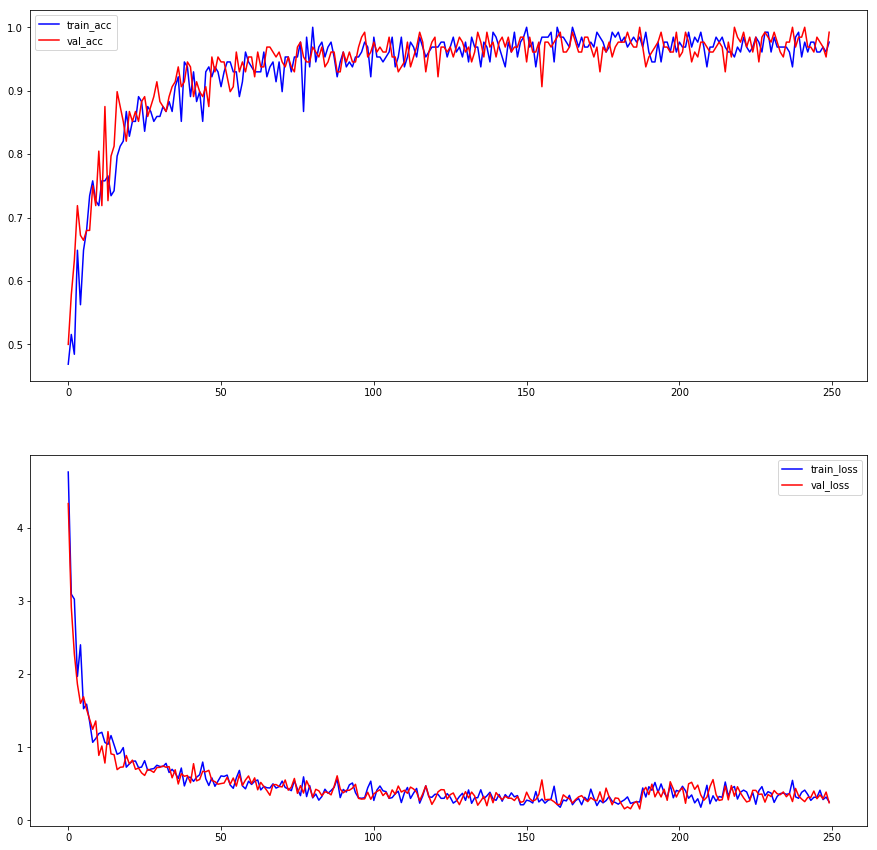

In [21]:
#Plot accuracy and loss
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.plot(hist['train_acc'],'-b',label='train_acc')
plt.plot(hist['val_acc'],'-r',label='val_acc')
plt.legend()
plt.subplot(212)
plt.plot(hist['train_loss'],'-b',label='train_loss')
plt.plot(hist['val_loss'],'-r',label='val_loss')
plt.legend()

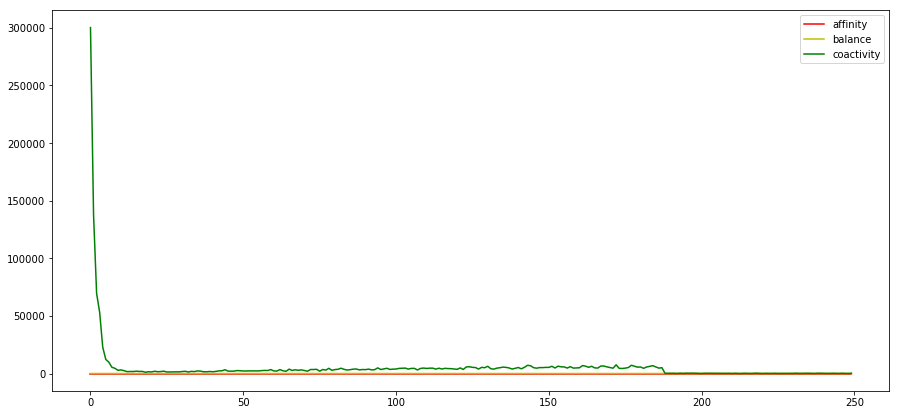

In [22]:
plt.figure(figsize=(15,7))
#plt.plot(hist['train_loss'],'-b',label='train_loss')
plt.plot(hist['affinity'],'-r',label='affinity')
plt.plot(np.subtract(1,hist['balance']),'-y',label='balance')
plt.plot(hist['coactivity'],'-g',label='coactivity')
plt.legend()

In [23]:
digitTrace = np.zeros((classCount*clustCount,784))
digitTraceCount = np.zeros((classCount*clustCount))
digitCount = np.zeros(20)

In [24]:
#sess.run(tf.global_variables_initializer())
for i in range(4000):
    testbatch = next_batch(1,True,test_images, test_labels,_epochs_completed_test,_index_in_epoch_test)
    #lbl = testbatch[2].ravel()
    #digitCount[np.argmax(lbl)]+=1
    smMat, acc = sess.run([softmaxMat,accuracy],feed_dict={x: testbatch[0], y_: testbatch[1]})
    ypred = softmaxMat.eval({x: testbatch[0], y_: testbatch[1]})
    ypred.reshape(clustCount*classCount)
    digitTrace[np.argmax(ypred),:] += testbatch[0].ravel()
    digitTraceCount[np.argmax(ypred)] += 1

In [25]:
print(digitCount)
print(digitTraceCount)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 446.  405.  420.  435.  363.  315.  355.  332.  466.  463.]


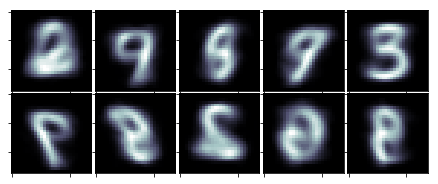

In [26]:
digitTrace = digitTrace/np.max(digitTrace)
f,ax=plt.subplots(nrows=classCount, ncols=clustCount, figsize=(1.5*clustCount,1.5*classCount))
gs = gridspec.GridSpec(classCount,clustCount)
gs.update(wspace=0.025, hspace=0.025)
f.subplots_adjust(wspace=0,hspace=0)
for i in range(digitTrace.shape[0]):
    sp = plt.subplot(gs[i])
    sp.set_xticklabels([])
    sp.set_yticklabels([])
    sp.set_aspect('equal')
    sp.grid = False
    plt.imshow(np.reshape(digitTrace[i,:],(28,28)),cmap='bone')

In [27]:
stepCount = len(hist['train_acc'])*100
with open('./trainlog.txt','ab') as f:
    f.write('lr: %g, batchsize: %i, steps: %i, thresh: %g, c1: %g, c2: %g, c3: %g, c4: %g, test_acc: %g, test_loss: %g\n'%
            (lr,batchSize,stepCount,tresh.eval(), cc1, cc2, cc3, cc4, test_acc, test_loss))

## Clustering score

In [28]:
testbatch = next_batch(5000,True,test_images, test_labels,_epochs_completed_test,_index_in_epoch_test)
lbls = testbatch[2].reshape(5000,clustCount*classCount)
testFeed = {x: testbatch[0], y_: testbatch[1]}
ypred = softmaxMat.eval(testFeed)
ypred = ypred.reshape((testbatch[0].shape[0],clustCount*classCount))
print(np.argmax(ypred,1).shape)
ypred = tf.argmax(ypred,1).eval()
ylookup = [np.argmax(np.sum(testbatch[2][ypred==i],0)).astype('int32') for i in range(clustCount*classCount)]
yconverted = [ylookup[i] for i in ypred]
correct_prediction = tf.equal(yconverted, np.argmax(lbls,1).astype('int32'))
clustAcc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).eval()
print('Clustering Accuracy: %g'%(clustAcc))
print(ylookup)
print(testbatch[2].shape)

(5000,)
Clustering Accuracy: 0.335
[1, 2, 1, 2, 0, 7, 5, 8, 6, 9]
(5000, 2, 5)


In [29]:
trainbatch = next_batch(10000,True,train_images, train_labels,_epochs_completed_train,_index_in_epoch_train)
trainlbls = trainbatch[2].reshape(10000,clustCount*classCount)
trainFeed = {x: trainbatch[0], y_: trainbatch[1]}
trainypred = softmaxMat.eval(trainFeed)
trainypred = trainypred.reshape((trainbatch[0].shape[0],clustCount*classCount))
trainypred = tf.argmax(trainypred,1).eval()
ylookup = [np.argmax(np.sum(trainbatch[2][trainypred==i],0)).astype('int32') for i in range(clustCount*classCount)]
print(ylookup)

[1, 2, 1, 3, 0, 7, 5, 8, 6, 9]


In [30]:
yconverted = [ylookup[i] for i in ypred]
correct_prediction = tf.equal(yconverted, np.argmax(lbls,1).astype('int32'))
clustAcc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).eval()
print('Clustering Accuracy: %g'%(clustAcc))
print(ylookup)
print(testbatch[2].shape)

Clustering Accuracy: 0.3344
[1, 2, 1, 3, 0, 7, 5, 8, 6, 9]
(5000, 2, 5)


In [31]:
notify("Superclass: %g \nSubclass: %g"%(testAcc,clustAcc))

## Compare it to k-means

In [32]:
tb0 = [tb[0][np.argmax(tb[1],1)<5],tb[1][np.argmax(tb[1],1)<5]]
tb1 = [tb[0][np.argmax(tb[1],1)>4],tb[1][np.argmax(tb[1],1)>4]]
#<5
kmeans = KMeans(n_clusters=5)
km0_ypred = kmeans.fit_transform(tb0[0])
km0_ypred = np.argmax(km0_ypred,1)
km_ylookup = [np.argmax(np.sum(tb0[1][km0_ypred==i],0)).astype('int32') for i in range(clustCount)]
km_yconverted = [km_ylookup[i] for i in km0_ypred]
km_correct_prediction = tf.equal(km_yconverted, np.argmax(tb0[1],1).astype('int32'))
km0_accuracy = tf.reduce_mean(tf.cast(km_correct_prediction, tf.float32)).eval()
#>4
kmeans = KMeans(n_clusters=5)
km1_ypred = kmeans.fit_transform(tb1[0])
km1_ypred = np.argmax(km1_ypred,1)
km_ylookup = [np.argmax(np.sum(tb1[1][km1_ypred==i],0)).astype('int32') for i in range(clustCount)]
km_yconverted = [km_ylookup[i] for i in km1_ypred]
km_correct_prediction = tf.equal(km_yconverted, np.argmax(tb1[1],1).astype('int32'))
km1_accuracy = tf.reduce_mean(tf.cast(km_correct_prediction, tf.float32)).eval()
print('ACOL Accuracy: %g'%(accuracy))
print('KMeans Accuracy: %g'%((km0_accuracy+km1_accuracy)/2))

NameError: name 'tb' is not defined

In [ ]:
#visualise kmeans
digitTrace = np.concatenate([[np.sum(tb0[0][km0_ypred==i,:],axis=0) for i in range(clustCount)],
                       [np.sum(tb1[0][km1_ypred==i,:],axis=0) for i in range(clustCount)]])
digitTrace = digitTrace/np.max(digitTrace)
f,ax=plt.subplots(nrows=classCount, ncols=clustCount, figsize=(1.5*clustCount,1.5*classCount))
gs = gridspec.GridSpec(classCount,clustCount)
gs.update(wspace=0.025, hspace=0.025)
f.subplots_adjust(wspace=0,hspace=0)
for i in range(digitTrace.shape[0]):
    sp = plt.subplot(gs[i])
    sp.set_xticklabels([])
    sp.set_yticklabels([])
    sp.set_aspect('equal')
    sp.grid = False
    plt.imshow(np.reshape(digitTrace[i,:],(28,28)),cmap='bone')

In [ ]:
t = next_batch(2,True,test_images, test_labels,_epochs_completed_test,_index_in_epoch_test)

In [ ]:
ims = t[0].reshape((-1,28,28))

In [ ]:
plt.imshow(ims[0])
print t[1][0]
print t[2][0]
plt.figure()
plt.imshow(ims[1])
print t[1][1]
print t[2][1]

In [ ]:
indexer = [slice(None)] * 3
indexer[1] = slice(None, None, -1)
t[2][tuple(indexer)]